                Issuer_Name Issuer_Location                  Issuer_Sector  \
0       360 ENERGY SOLAR SA       Argentina             Corporate - Energy   
1  A.P. MOLLER - MAERSK A/S         Denmark        Corporate - Industrials   
2                A2A S.P.A.           Italy          Corporate - Utilities   
3            AAREAL BANK AG         Germany  Financials - Consumer Finance   
4  AARGAUISCHE KANTONALBANK     Switzerland           Financials - Banking   

   Interest_Rate Credit_Rating  Credit_Rating_Numeric  ESG_Score  \
0       2.185431           AAA                      1  92.517400   
1       4.778214             A                      3  60.599703   
2       3.793973             B                      6  82.867674   
3       3.193963           AAA                      1  73.614090   
4       1.202084           BBB                      4  94.007837   

   Market_Demand  Inflation_Rate  Government_Support  Project_Risk  Liquidity  \
0      85.472856        2.259805         

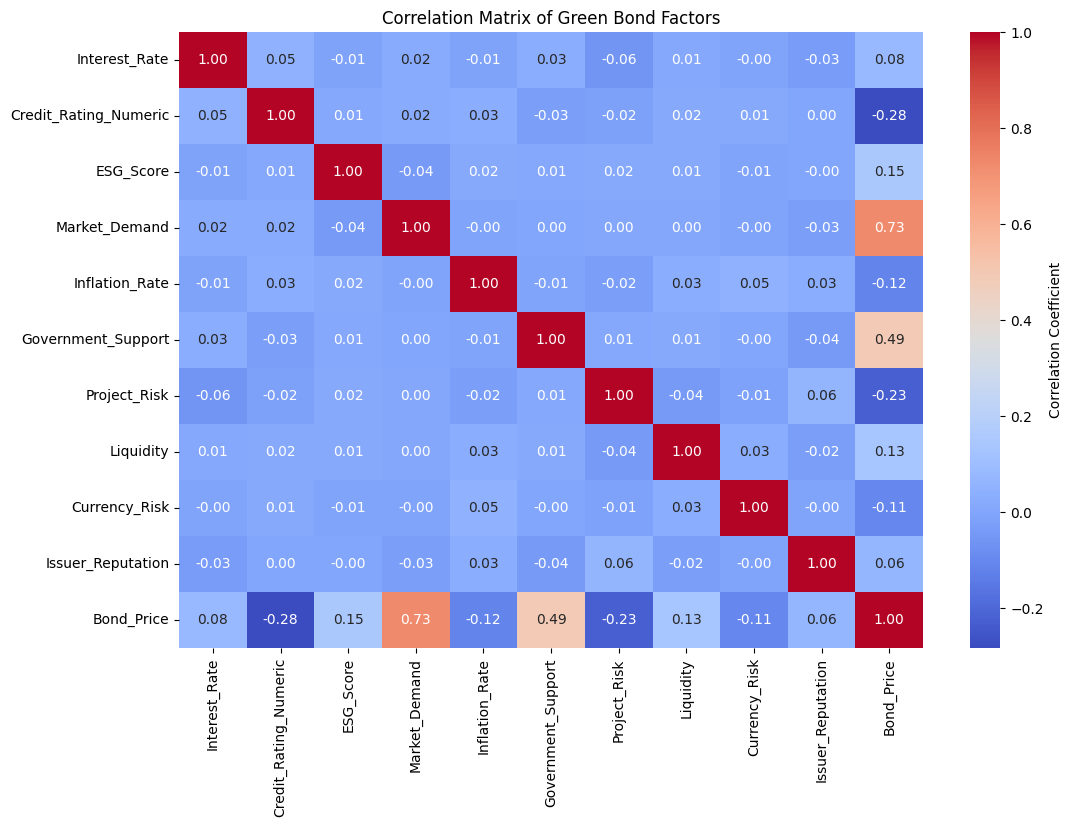

CatBoost Regressor - MSE: 1.8386, R2 Score: 0.8402
Random Forest Classifier - Accuracy: 0.5073

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.50      0.51       246
           1       0.50      0.52      0.51       235

    accuracy                           0.51       481
   macro avg       0.51      0.51      0.51       481
weighted avg       0.51      0.51      0.51       481

Gradient Boosting Classifier - Accuracy: 0.5281

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       246
           1       0.52      0.54      0.53       235

    accuracy                           0.53       481
   macro avg       0.53      0.53      0.53       481
weighted avg       0.53      0.53      0.53       481

XGBoost Classifier - Accuracy: 0.4990

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.47     

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor

# Set random seed for reproducibility
np.random.seed(42)

# Load the Excel file
file_path = '/kaggle/input/blackrock/Book1.xlsx'
excel_data = pd.read_excel(file_path)

# Number of samples
num_samples = len(excel_data)

# Generate synthetic data for each factor
interest_rate = np.random.uniform(0.5, 5.0, num_samples)
credit_rating = np.random.choice(['AAA', 'AA', 'A', 'BBB', 'BB', 'B'], num_samples)
esg_score = np.random.uniform(50, 100, num_samples)
market_demand = np.random.uniform(50, 150, num_samples)
inflation_rate = np.random.uniform(0.5, 3.5, num_samples)
government_support = np.random.uniform(0, 10, num_samples)
project_risk = np.random.uniform(0, 10, num_samples)
liquidity = np.random.uniform(0, 10, num_samples)
currency_risk = np.random.uniform(0, 5, num_samples)
issuer_reputation = np.random.uniform(50, 100, num_samples)

# Define credit rating to numeric conversion
credit_rating_to_numeric = {'AAA': 1, 'AA': 2, 'A': 3, 'BBB': 4, 'BB': 5, 'B': 6}
credit_rating_numeric = np.array([credit_rating_to_numeric[r] for r in credit_rating])

# Calculate bond prices
bond_price = (
    100 + 
    0.5 * interest_rate -
    2 * credit_rating_numeric +
    1.5 * (esg_score / 10) +
    0.3 * market_demand -
    1.5 * inflation_rate +
    2 * government_support -
    1 * project_risk +
    0.5 * liquidity -
    0.8 * currency_risk +
    1 * (issuer_reputation / 10)
)

# Normalize bond prices to a realistic range
scaler = MinMaxScaler(feature_range=(90, 110))
bond_price_normalized = scaler.fit_transform(bond_price.reshape(-1, 1)).flatten()

# Create a DataFrame combining Excel data with synthetic data
data = pd.DataFrame({
    'Issuer_Name': excel_data['Issuer Name'],
    'Issuer_Location': excel_data['Issuer location'],
    'Issuer_Sector': excel_data['Issuer sector'],
    'Interest_Rate': interest_rate,
    'Credit_Rating': credit_rating,
    'Credit_Rating_Numeric': credit_rating_numeric,
    'ESG_Score': esg_score,
    'Market_Demand': market_demand,
    'Inflation_Rate': inflation_rate,
    'Government_Support': government_support,
    'Project_Risk': project_risk,
    'Liquidity': liquidity,
    'Currency_Risk': currency_risk,
    'Issuer_Reputation': issuer_reputation,
    'Bond_Price': bond_price_normalized
})

# Display the first few rows of the dataset
print(data.head())

# Save the dataset to a CSV file
data.to_csv('synthetic_green_bond_data_with_real_issuers.csv', index=False)

# Calculate correlations only for numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Visualize correlations between numeric factors
plt.figure(figsize=(12, 8))
sns.heatmap(data[numeric_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix of Green Bond Factors")
plt.show()

# Data Preprocessing
data = data.dropna()
data = data.drop(['Issuer_Name', 'Issuer_Location', 'Issuer_Sector', 'Credit_Rating'], axis=1)
data['Unique_ID'] = range(1, len(data) + 1)

# Standardize numerical features
numerical_columns = data.columns.difference(['Bond_Price', 'Credit_Rating', 'Unique_ID'])
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Define the Risk Factor
data['Risk_Factor'] = data['Credit_Rating_Numeric'] + data['Project_Risk'] - data['Liquidity']

# Create a binary target variable indicating whether to invest in the bond
threshold = data['Risk_Factor'].median()
data['Invest'] = (data['Risk_Factor'] < threshold).astype(int)

# Splitting the Data for Bond Price Prediction
X = data[['Market_Demand', 'Government_Support', 'Invest']]
y = data['Bond_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a CatBoost Regressor for Bond Price Prediction
catboost_regressor = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
catboost_regressor.fit(X_train, y_train)

# Make predictions for Bond Price Prediction
y_pred = catboost_regressor.predict(X_test)

# Evaluate the regressor
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"CatBoost Regressor - MSE: {mse:.4f}, R2 Score: {r2:.4f}")

# Splitting the Data for Investment Decision Prediction
X_invest = data[['Market_Demand', 'Government_Support']]
y_invest = data['Invest']
X_invest_train, X_invest_test, y_invest_train, y_invest_test = train_test_split(X_invest, y_invest, test_size=0.3, random_state=42)

# Define models
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_invest_train, y_invest_train)
    y_invest_pred = clf.predict(X_invest_test)
    accuracy = accuracy_score(y_invest_test, y_invest_pred)
    print(f"{name} Classifier - Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_invest_test, y_invest_pred))


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

# Step 1: Load the CSV file
file_path = '/kaggle/input/green-bond-synthetically-generated-dataset-1/synthetic_green_bond_data_with_real_issuers (2).csv'
data = pd.read_csv(file_path)

# Step 2: Handling Missing Values
data = data.dropna()

# Step 3: Drop specified columns and add a unique numeric identifier for each row
data = data.drop(['Issuer_Name', 'Issuer_Location', 'Issuer_Sector', 'Credit_Rating'], axis=1)
data['Unique_ID'] = range(1, len(data) + 1)

# Step 4: Select only the 'Market_Demand' and 'Government_Support' columns for training
selected_features = ['Market_Demand', 'Government_Support']

# Step 5: Standardize numerical features
scaler = StandardScaler()
data[selected_features] = scaler.fit_transform(data[selected_features])

# Step 6: Splitting the Data
X = data[selected_features]
y = data['Bond_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 7: Hyperparameter tuning using GridSearchCV for CatBoost
catboost_params = {
    'iterations': [100, 200, 300, 400],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 50, 64]
}

# Initialize CatBoostRegressor
catboost = CatBoostRegressor(random_seed=42, verbose=0)

# Perform GridSearchCV
grid_search = GridSearchCV(catboost, catboost_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_catboost = grid_search.best_estimator_

# Output best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model on the test set
predictions = best_catboost.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Best CatBoost - MSE: {mse:.4f}, R2 Score: {r2:.4f}")

# Train the best model on the entire dataset
best_catboost.fit(X, y)

# Function to preprocess future data
def preprocess_future_data(future_data):
    # Ensure the future data has the same columns as the training data
    future_data = future_data[selected_features]
    # Standardize the future data using the same scaler
    future_data = scaler.transform(future_data)
    return future_data

Best parameters found:  {'border_count': 50, 'depth': 6, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.05}
Best CatBoost - MSE: 2.6992, R2 Score: 0.7654


In [6]:
# Take user input for future data
market_demand_input = float(input("Enter Market Demand (e.g., 0.5): "))
government_support_input = float(input("Enter Government Support (e.g., 0.3): "))

# Example future data for prediction
future_data = pd.DataFrame({
    'Market_Demand': [market_demand_input],
    'Government_Support': [government_support_input]
})

# Preprocess the future data
future_data_preprocessed = preprocess_future_data(future_data)

# Predict future bond prices
future_predictions = best_catboost.predict(future_data_preprocessed)

# Output the predictions
print("Predicted future bond price:", future_predictions[0])

Enter Market Demand (e.g., 0.5):  100
Enter Government Support (e.g., 0.3):  50


Predicted future bond price: 103.60794674052126


In [8]:
import pickle
model_filename = '/kaggle/working/best_catboost_model.pkl'
scaler_filename = '/kaggle/working/scaler.pkl'

with open(model_filename, 'wb') as model_file:
    pickle.dump(best_catboost, model_file)

with open(scaler_filename, 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print(f"Model saved to {model_filename}")
print(f"Scaler saved to {scaler_filename}")

Model saved to /kaggle/working/best_catboost_model.pkl
Scaler saved to /kaggle/working/scaler.pkl


In [ ]:
pip install streamlit


In [ ]:
import streamlit as st
import pandas as pd
import pickle
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler

# Load the trained model and scaler
model_filename = 'best_catboost_model.pkl'
scaler_filename = 'scaler.pkl'

with open(model_filename, 'rb') as model_file:
    model = pickle.load(model_file)

with open(scaler_filename, 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

# Streamlit UI
st.title('Green Bond Price Prediction')

# User inputs
market_demand = st.number_input('Market Demand', min_value=-10.0, max_value=10.0, value=0.0)
government_support = st.number_input('Government Support', min_value=-10.0, max_value=10.0, value=0.0)

if st.button('Predict'):
    # Prepare the input data
    input_data = pd.DataFrame({
        'Market_Demand': [market_demand],
        'Government_Support': [government_support]
    })

    # Preprocess the input data
    input_data_scaled = scaler.transform(input_data)

    # Make prediction
    prediction = model.predict(input_data_scaled)[0]

    # Show prediction
    st.write(f'Predicted Bond Price: ${prediction:.2f}')
